Let's first install some tools.

In [1]:
%pip install scikit-learn scikit-lego

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 kB 5.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 59.4 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 51.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 52.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 76.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Voting Classifier

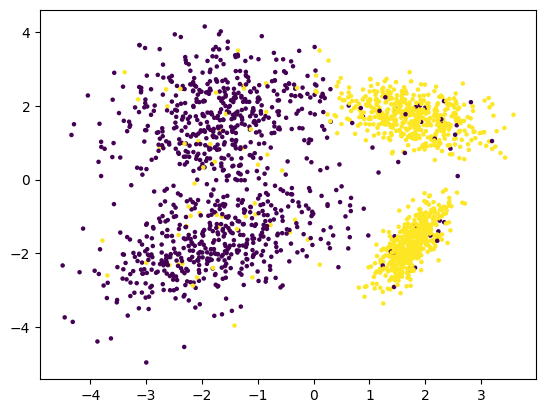

In [3]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=2000, n_features=2,
                           n_redundant=0, random_state=21,
                           class_sep=1.75, flip_y=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

In [4]:
def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens3");

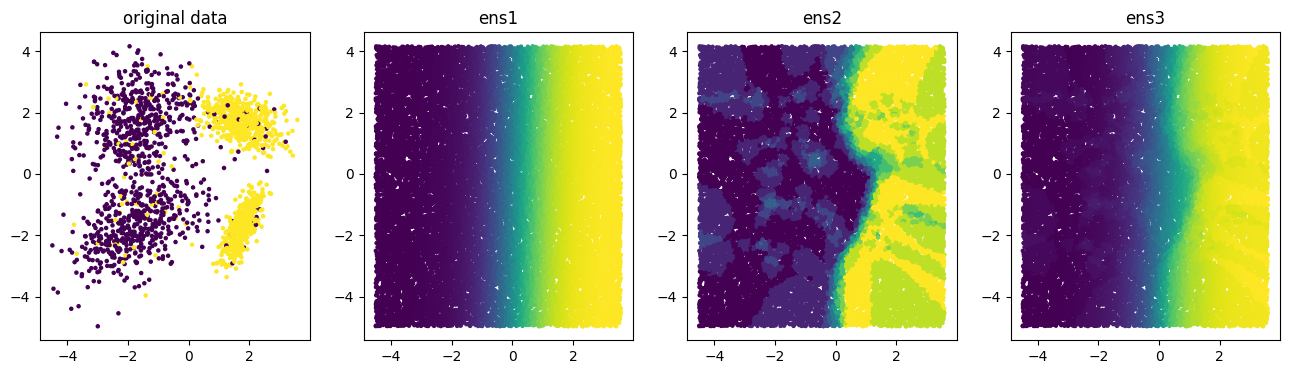

In [5]:
clf1 = LogisticRegression().fit(X, y)
clf2 = KNeighborsClassifier(n_neighbors=10).fit(X, y)
clf3 = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2)],
                        voting='soft',
                        weights=[10.5, 2.5])
clf3.fit(X, y)

make_plots()

## Threshold

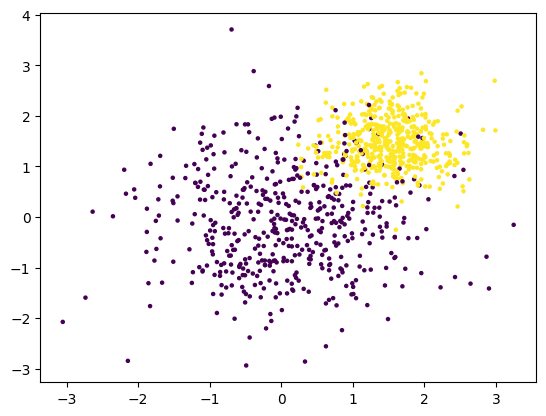

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from sklego.meta import Thresholder

X, y = make_blobs(1000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

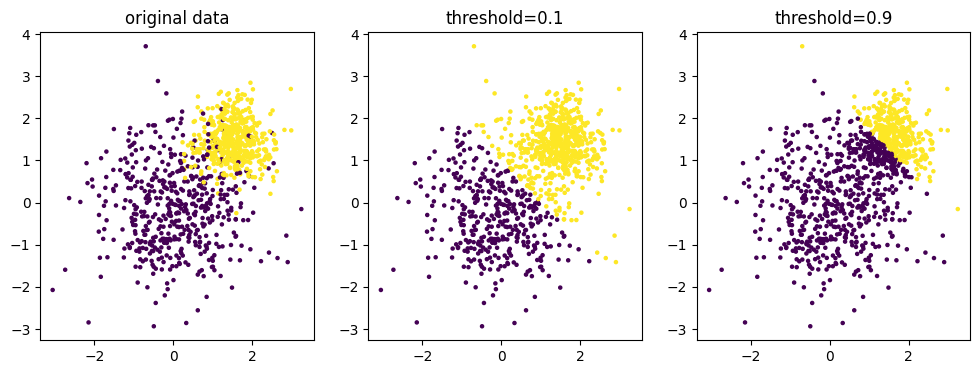

In [7]:
#Limited Memory Broyden–Fletcher–Goldfarb–Shanno solver
m1 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1).fit(X, y)
m2 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.9).fit(X, y)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
plt.title("original data")
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=m1.predict(X), s=5)
plt.title("threshold=0.1")
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=m2.predict(X), s=5)
plt.title("threshold=0.9");

In [18]:
pipe = Pipeline([
    ("model", Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])

mod = GridSearchCV(estimator=pipe,
                  param_grid = {"model__threshold": np.linspace(0.1, 0.9, 50)},
                  scoring={"precision": make_scorer(precision_score),
                            "recall": make_scorer(recall_score),
                            "accuracy": make_scorer(accuracy_score)},
                  refit="precision",
                  cv=5)

mod.fit(X, y)
mod.predict(X);

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,

## Grouped Models

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklego.datasets import load_chicken
from sklego.preprocessing import ColumnSelector

df = load_chicken(as_frame=True)

def plot_model(model):
    df = load_chicken(as_frame=True)
    model.fit(df[['diet', 'time']], df['weight'])
    metric_df = df[['diet', 'time', 'weight']].assign(pred=lambda d: model.predict(d[['diet', 'time']]))
    metric = mean_absolute_error(metric_df['weight'], metric_df['pred'])
    plt.figure(figsize=(12, 4))
    # plt.scatter(df['time'], df['weight'])
    for i in [1, 2, 3, 4]:
        pltr = metric_df[['time', 'diet', 'pred']].drop_duplicates().loc[lambda d: d['diet'] == i]
        plt.plot(pltr['time'], pltr['pred'], color='.rbgy'[i])
    plt.title(f"linear model per group, MAE: {np.round(metric, 2)}");

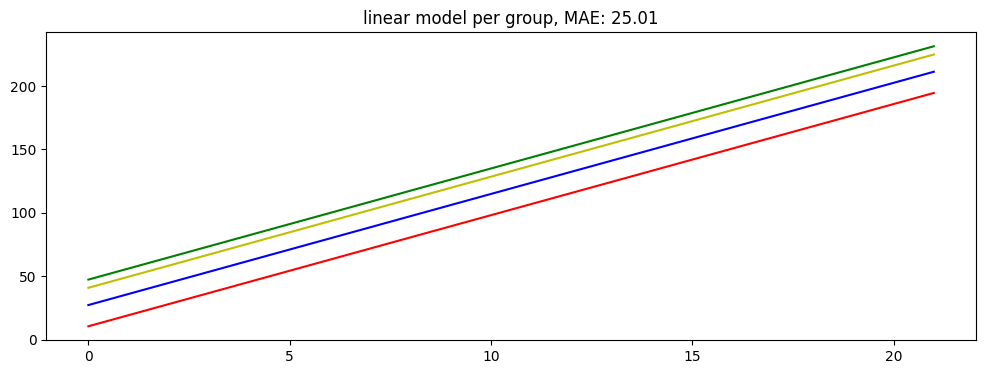

In [11]:
feature_pipeline = Pipeline([
    ("datagrab", FeatureUnion([
        ("discrete", Pipeline([
            ("grab", ColumnSelector("diet")),
            ("encode", OneHotEncoder(categories="auto", sparse=False))
        ])),
        ("continuous", Pipeline([
            ("grab", ColumnSelector("time")),
            ("standardize", StandardScaler())
        ]))
    ]))
])

pipe = Pipeline([
    ("transform", feature_pipeline),
    ("model", LinearRegression())
])

plot_model(pipe)

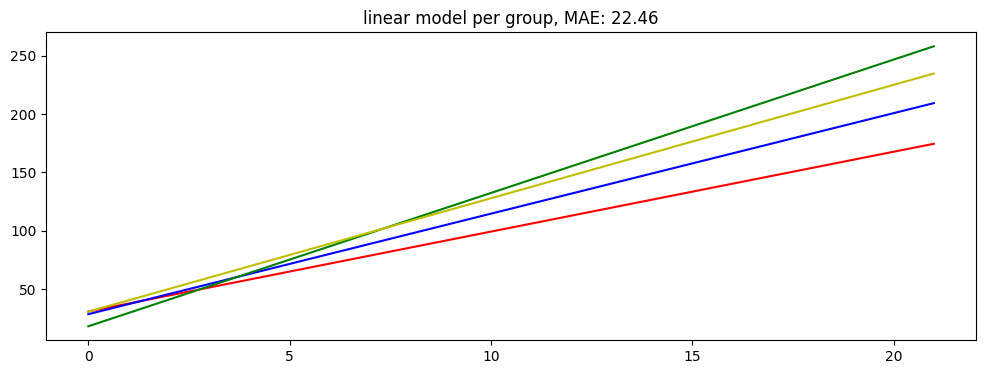

In [19]:
from sklego.meta import GroupedPredictor
mod = GroupedPredictor(LinearRegression(), groups=["diet"])
plot_model(mod)

### Zero Inflated Regression

In [28]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklego.meta import ZeroInflatedRegressor

# Note the final line of code in this block. We're setting y=0 for all weekend dates
# while we simulate standard regression data for all the other dates.
df = (pd.DataFrame({'dt': pd.date_range("2018-01-01", "2021-01-01")})
      .assign(x=lambda d: np.random.normal(0, 1, d.shape[0]))
      .assign(weekend = lambda d: (d['dt'].dt.weekday >= 5).astype(np.int16))
      .assign(y=lambda d: np.where(d['weekend'], 0, 1.5 + 0.87 * d['x'] + np.random.normal(0, 0.2, d.shape[0]))))

In [29]:
X, y = df[['x', 'weekend']].values, df['y'].values

In [38]:
zir = ZeroInflatedRegressor(
    classifier=LogisticRegression(),
    regressor=Ridge()
)

lr = Ridge(random_state=0)

print('ZIR r²:', round(int(cross_val_score(zir, X, y).mean()*100),2))
print(' LR r²:', round(int(cross_val_score(lr, X, y).mean()*100),2))

ZIR r²: 97
 LR r²: 83


### Decay

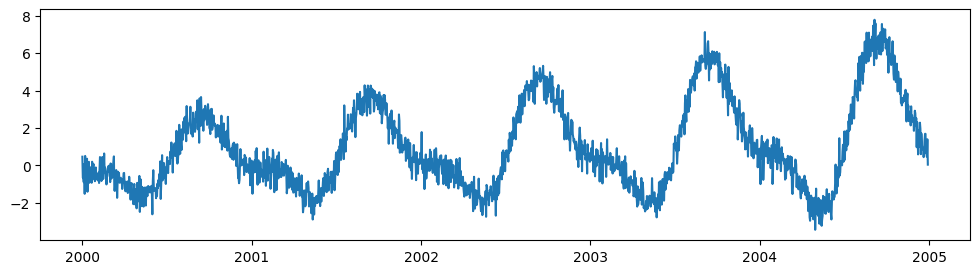

In [24]:
from sklearn.dummy import DummyRegressor
from sklego.meta import GroupedPredictor, DecayEstimator
from sklego.datasets import make_simpleseries
import matplotlib.pylab as plt 

yt = make_simpleseries(seed=1)
dates = pd.date_range("2000-01-01", periods=len(yt))
df = (pd.DataFrame({"yt": yt,
                  "date": dates})
      .assign(m=lambda d: d.date.dt.month_name())
      .reset_index())

plt.figure(figsize=(12, 3))
plt.plot(dates, make_simpleseries(seed=1));

In [25]:
df

,index,yt,date,m
0,0,0.468623,2000-01-01,January
1,1,-0.653622,2000-01-02,January
2,2,-0.615641,2000-01-03,January
3,3,-0.891481,2000-01-04,January
4,4,0.074618,2000-01-05,January
...,...,...,...,...
1820,1820,0.650863,2004-12-25,December
1821,1821,0.859795,2004-12-26,December
1822,1822,0.470901,2004-12-27,December
1823,1823,1.399010,2004-12-28,December


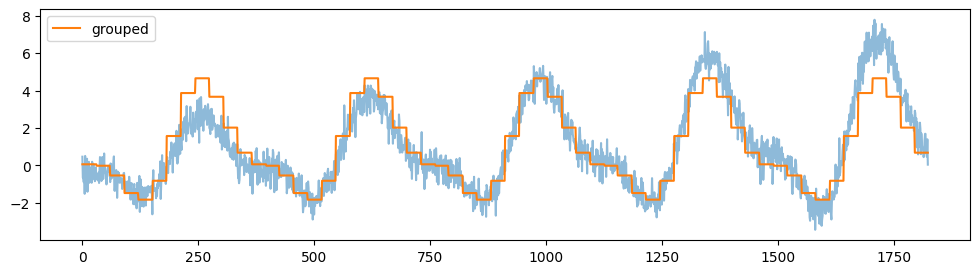

In [26]:
mod1 = (GroupedPredictor(DummyRegressor(), groups=["m"])
  .fit(df[['m']], df['yt']))

plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.legend();

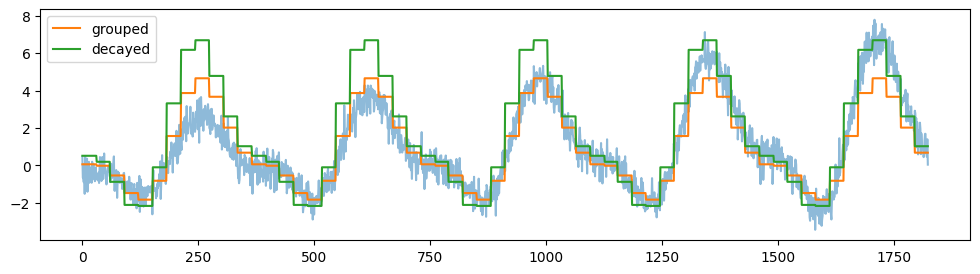

In [27]:
mod1 = (GroupedPredictor(DummyRegressor(), groups=["m"])
  .fit(df[['m']], df['yt']))

mod2 = (GroupedPredictor(DecayEstimator(DummyRegressor(), decay=0.9), groups=["m"])
        .fit(df[['index', 'm']], df['yt']))

plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.plot(mod2.predict(df[['index', 'm']]), label="decayed")
plt.legend();